# <span style='color :yellow' > **Dependancies** </span>

In [6]:
import numpy as np
import cv2 
import random
import math
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchinfo import summary

# <span style='color :yellow' > **Advanced Image Processing: Pixel Expansion and Noise Addition** </span>

### Task 1: Single Pixel Expansion to Multiple Pixels

<span style="background:red">Importing Image</span>

In [7]:
image_path = 'Lenna_(test_image).png'
original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # numpy.ndarray

In [8]:
type(original)

numpy.ndarray

In [9]:
def valDecide(val, expansionStrategy, neighbors=None, scale=2):
    '''
        TODO: decides the value of the block to be expanded
        \param val (int): value of the pixel
        \param expansionStrategy (str): type of expansion
        \param neighbors (dict): neighbors of the pixel
        \param scale (int): scale of the block

        \return block (numpy.ndarray): block of size (scale, scale)
    '''
    if expansionStrategy == "Constant":
        return np.full((scale, scale), val, dtype=np.uint8)
    
    elif expansionStrategy == "Gradient":
        if neighbors is None:
            return np.full((scale, scale), val, dtype=np.uint8)
        
        NW = val
        NE = neighbors.get("right", val)
        SW = neighbors.get("below", val)
        SE = neighbors.get("below_right", val)
        
        gradient_block = np.zeros((scale, scale), dtype=np.float32)
        for i in range(scale):
            for j in range(scale):
                gradient_block[i, j] = (
                    NW * (1 - i / (scale - 1)) * (1 - j / (scale - 1))
                    + NE * (1 - i / (scale - 1)) * (j / (scale - 1))
                    + SW * (i / (scale - 1)) * (1 - j / (scale - 1))
                    + SE * (i / (scale - 1)) * (j / (scale - 1))
                )
        
        return np.clip(gradient_block, 0, 255).astype(np.uint8)  
    
    elif expansionStrategy == "Random":
        return np.random.randint(max(0, int(0.7 * val)), min(255, int(1.3 * val)), size=(scale, scale), dtype=np.uint8)


def pixelExpansion(image, scale, expansionStrategy):
    '''
        TODO: expands each pixel of an input image to a block
        \param image (numpy.ndarray): input greyscale image of size (i, j)
        \param scale (int): block size
        \param expansionStrategy (str): type of expansion
        
        \return final_image (numpy.ndarray): expanded image of size (i * scale, j * scale)
    '''
        
    height, width = image.shape
    final_image = np.zeros((height*scale, width*scale), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            neighbors = {}
            if i < height - 1:
                neighbors["below"] = image[i + 1, j]
            if j < width - 1:
                neighbors["right"] = image[i, j + 1]
            if i < height - 1 and j < width - 1:
                neighbors["below_right"] = image[i + 1, j + 1]
            
            block = valDecide(image[i, j], expansionStrategy, neighbors=neighbors, scale=scale)
            
            final_image[
                i * scale:(i + 1) * scale,
                j * scale:(j + 1) * scale
            ] = block
    
    return final_image


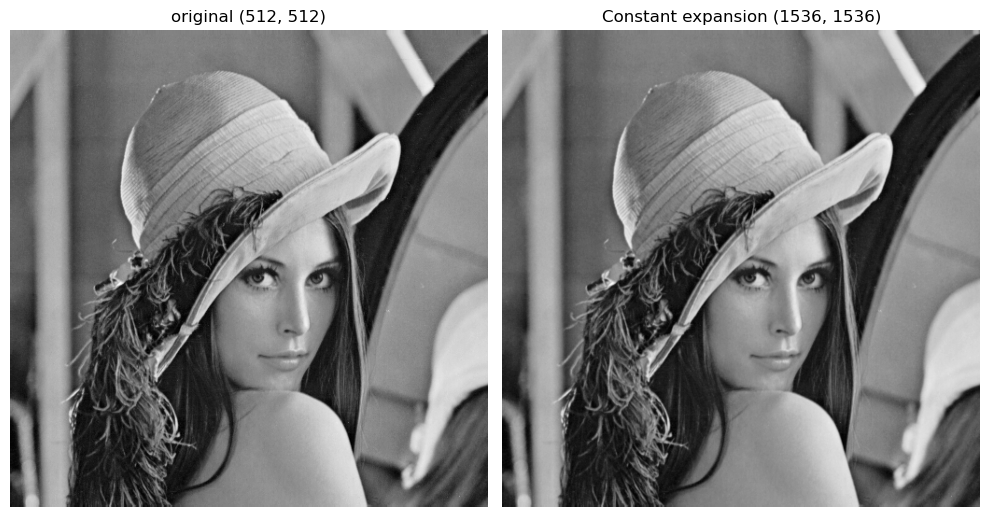

In [10]:
def display_expanded_image(scale, expansionStrategy): 
    expanded = pixelExpansion(original, scale, expansionStrategy)
    
    IMAGES = {
        f"original {original.shape}" : original,
        f"{expansionStrategy} expansion {expanded.shape}" : expanded
    }
    
    plt.figure(figsize=(10, 6))
    for i, (key, img) in enumerate(IMAGES.items()):
        plt.subplot(1, 2, i+1)
        plt.title(key)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
display_expanded_image(scale = 3, expansionStrategy = "Constant")

### Task 2: Adding Noise to an Image

In [11]:
def gaussian(image, mean=0, std=25, intensity=1.0):
    '''
    TODO: Add Gaussian noise to an image(Lena image)
    \param image (numpy.ndarray): input image array
    \param mean (float): mean of the Gaussian noise distribution
    \param std (float): standard deviation of the Gaussian noise
    \param intensity (float): scaling factor for noise intensity

    \return noisy_image (numpy.ndarray): image with added Gaussian noise
    '''
    std_scaled = std * intensity 
    noise = np.random.normal(mean, std_scaled, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def saltNpepper(image, salt_prob=0.01, pepper_prob=0.01, intensity=1.0):
    '''
    TODO: Add salt and pepper noise to an image
    \param image (numpy.ndarray): input image array
    \param salt_prob (float): probability of adding salt noise
    \param pepper_prob (float): probability of adding pepper noise
    \param intensity (float): scaling factor for noise intensity

    \return noisy_image (numpy.ndarray): image with added salt and pepper noise
    '''
    noisy_image = image.copy()
    total_pixels = image.size
    # intensity scaling
    salt_prob_scaled = salt_prob * intensity
    pepper_prob_scaled = pepper_prob * intensity
    # salt noise
    num_salt = int(total_pixels * salt_prob_scaled)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[tuple(salt_coords)] = 255
    # pepper noise
    num_pepper = int(total_pixels * pepper_prob_scaled)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[tuple(pepper_coords)] = 0
    
    return noisy_image

def poisson(image, intensity=1.0):
    '''
    TODO: Add Poisson noise to an image
    \param image (numpy.ndarray): input image array
    \param intensity (float): scaling factor for noise intensity

    \return noisy_image (numpy.ndarray): image with added Poisson noise
    '''
    # (higher intensity = more noise)
    scaling_factor = 100 / intensity
    noisy_scaled = np.random.poisson(image / 255.0 * scaling_factor)
    noisy_image = (noisy_scaled / scaling_factor) * 255
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# select noise level       
Noisy_Images = {
    "original" : original,
    "gaussian" : gaussian(original, mean=0, std=25),
    "saltNpepper" : saltNpepper(original, salt_prob=0.03, pepper_prob=0.05),
    "poisson" : poisson(original)
}

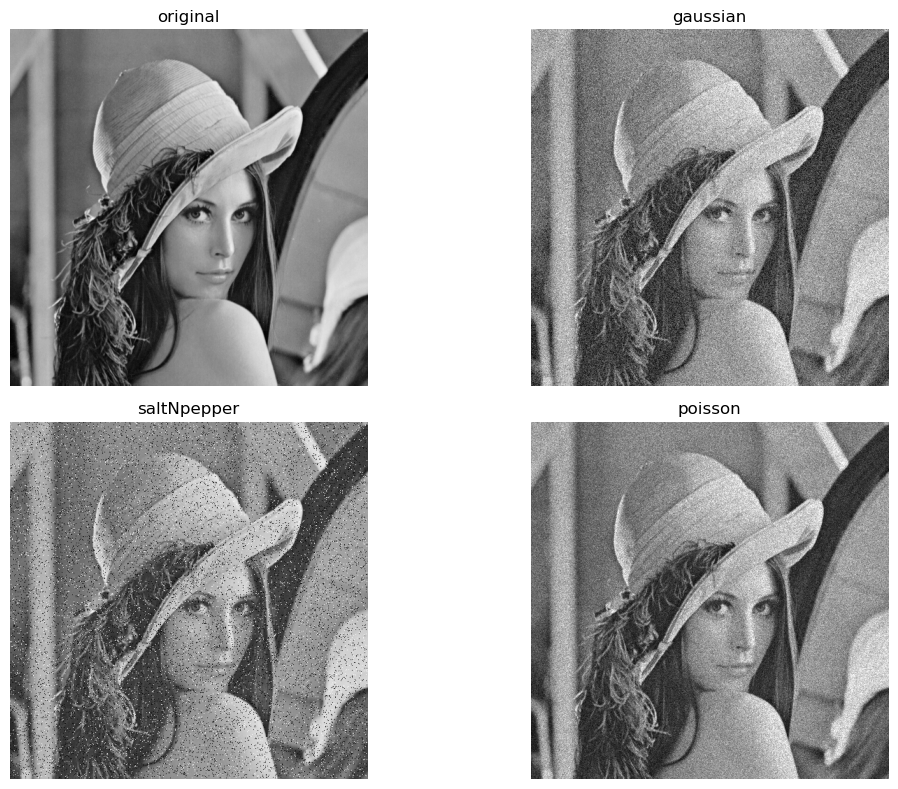

In [12]:
def display_noisy_images():
    plt.figure(figsize=(12, 8))
    for i, (noise, img) in enumerate(Noisy_Images.items()):
        plt.subplot(2, 2, i+1)
        plt.title(noise)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_noisy_images()

### Task 3: Evaluating Image Quality

In [13]:
def compute_mse(original, noisy):
    '''
    TODO: Compute Mean Squared Error between two images
    \param original (numpy.ndarray): original image array
    \param noisy (numpy.ndarray): noisy image array

    \return mse (float): mean squared error between the images
    '''
    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)
    return np.mean((original - noisy) ** 2)

def compute_psnr(original, noisy):
    '''
    TODO: Compute Peak Signal-to-Noise Ratio between two images
    \param original (numpy.ndarray): original image array
    \param noisy (numpy.ndarray): noisy image array

    \return psnr (float): peak signal-to-noise ratio between the images
    '''
    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)
    mse = compute_mse(original, noisy)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

def compute_ssim_manual(original, noisy, L=255):
    '''
    TODO: Compute Structural Similarity Index between two images
    \param original (numpy.ndarray): original image array
    \param noisy (numpy.ndarray): noisy image array
    \param L (int): maximum pixel value

    \return ssim (float): structural similarity index between the images
    '''
    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)
    c1 = (0.01*L)**2
    c2 = (0.03*L)**2
    muX = original.mean()
    muY = noisy.mean()
    sigX = original.var()
    sigY = noisy.var()
    cVar = np.cov(original.flatten(), noisy.flatten())[0, 1]

    return ((2*muX*muY) + c1) * (2*cVar + c2) / ((muX**2) + (muY**2) + c1) * (sigX + sigY + c2)

def evaluate_image_quality(original, noisy_images):
    '''
    TODO: Compute Mean Squared Error, Peak Signal-to-Noise Ratio, and Structural Similarity Index between two images
    \param original (numpy.ndarray): original image array
    \param noisy_images (dict): dictionary of noisy image arrays

    \return metrics (dict): dictionary of metrics
    '''
    metrics = {}
    for noise_type, noisy_image in noisy_images.items():
        mse = compute_mse(original, noisy_image)
        psnr = compute_psnr(original, noisy_image)
        ssim_value = compute_ssim_manual(original, noisy_image)
        metrics[noise_type] = {
            "MSE": mse,
            "PSNR": psnr,
            "SSIM": ssim_value
        }
    return metrics

def display_metrics(metrics):
    print(f"{'Noise Type':<15} {'MSE':<10} {'PSNR':<10} {'SSIM':<10}")
    print("-" * 40)
    for noise_type, values in metrics.items():
        print(f"{noise_type:<15} {values['MSE']:<10.2f} {values['PSNR']:<10.2f} {values['SSIM']:<10.4f}")

metrics = evaluate_image_quality(original, Noisy_Images)
display_metrics(metrics)

Noise Type      MSE        PSNR       SSIM      
----------------------------------------
original        0.00       inf        16735686.4539
gaussian        618.57     20.22      19193095.2984
saltNpepper     1432.53    16.57      19673215.6695
poisson         336.08     22.87      18074356.1194


# <span style='color :yellow' > **Understanding CNN Layers: Filters, Activations, and Noise Impact** </span>

### Task 1: CNN Layer Anatomy & Filter Visualization

1. Load a Pretrained CNN

<span style='background-color:red'>Model Summary</span>

In [14]:
model = models.vgg16(pretrained=True)
model.eval()
summary(model)

/Users/vishwanathanayyappan/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vishwanathanayyappan/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

2. Extract and Visualize Filters

In [15]:
convLayers = {} # dict: conv layers
cnt = 1
for id, layer in enumerate(model.features):
    if type(layer) == torch.nn.modules.conv.Conv2d:
        filters = layer.weight.data.clone()
        convLayers[f"conv{cnt}"] = (filters - filters.min()) / (filters.max() - filters.min())
        # print(id)
        cnt += 1

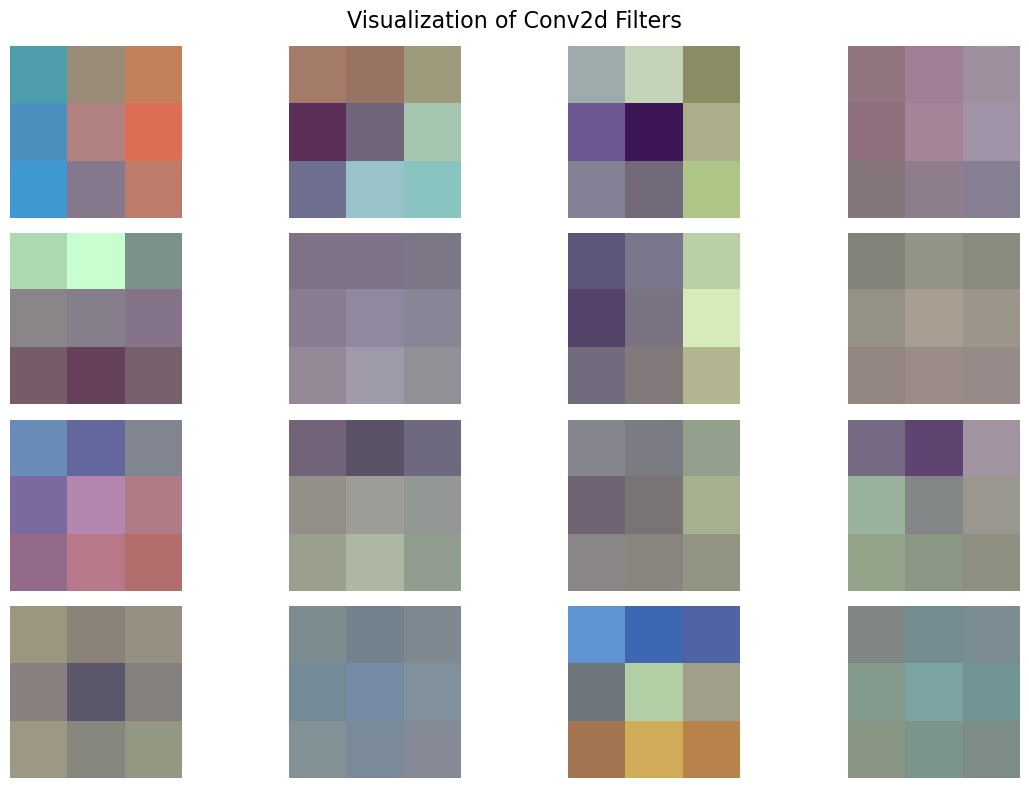

In [16]:
def visualize_filters(filters, num_filters=16):
    '''
    TODO: Visualize filters from a convolutional layer
    \param filters (torch.Tensor): tensor containing the filters to visualize
    \param num_filters (int): number of filters to visualize 
    
    \return None: displays the filter visualizations
    '''
    filters = filters[:num_filters]
    plt.figure(figsize=(12, 8))
    for i in range(num_filters):
        plt.subplot(4, 4, i + 1)  
        if filters.shape[1] == 3: 
            plt.imshow(filters[i].permute(1, 2, 0)) 
        else:  
            plt.imshow(filters[i][0], cmap='gray')  
        plt.axis('off')
    plt.suptitle("Visualization of Conv2d Filters", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_filters(convLayers["conv1"])

### Task 2: Feature Map (Activation) Visualization

In [17]:
image = Image.open(image_path) #.convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

input_image = preprocess(image).unsqueeze(0)  
activations = {}
def hook_fn(module, input, output):
    activations[module] = output
    
model.features[0].register_forward_hook(hook_fn)   
model.features[5].register_forward_hook(hook_fn) 
model.features[28].register_forward_hook(hook_fn)  

with torch.no_grad():
    _ = model(input_image)

def displayFeatureMaps(feature_maps, title, num_maps=16):
    feature_maps = feature_maps.squeeze(0)[:num_maps]

    plt.figure(figsize=(12, 8))
    for i in range(num_maps):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i].cpu().numpy(), cmap='viridis')  
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

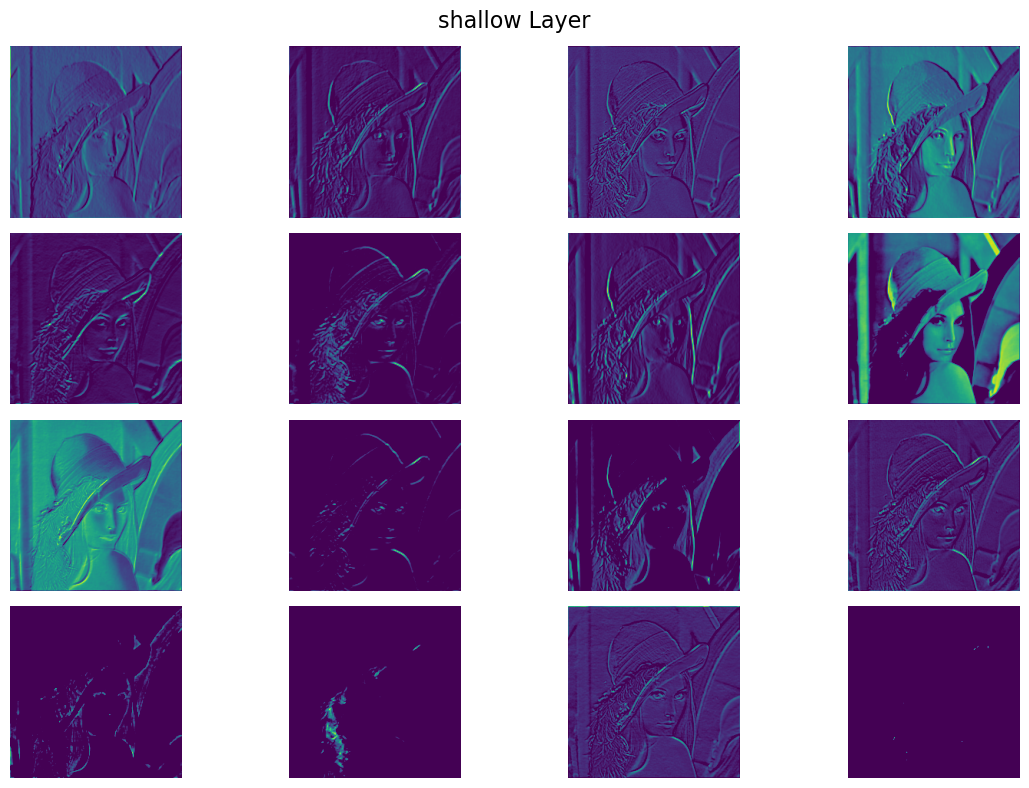

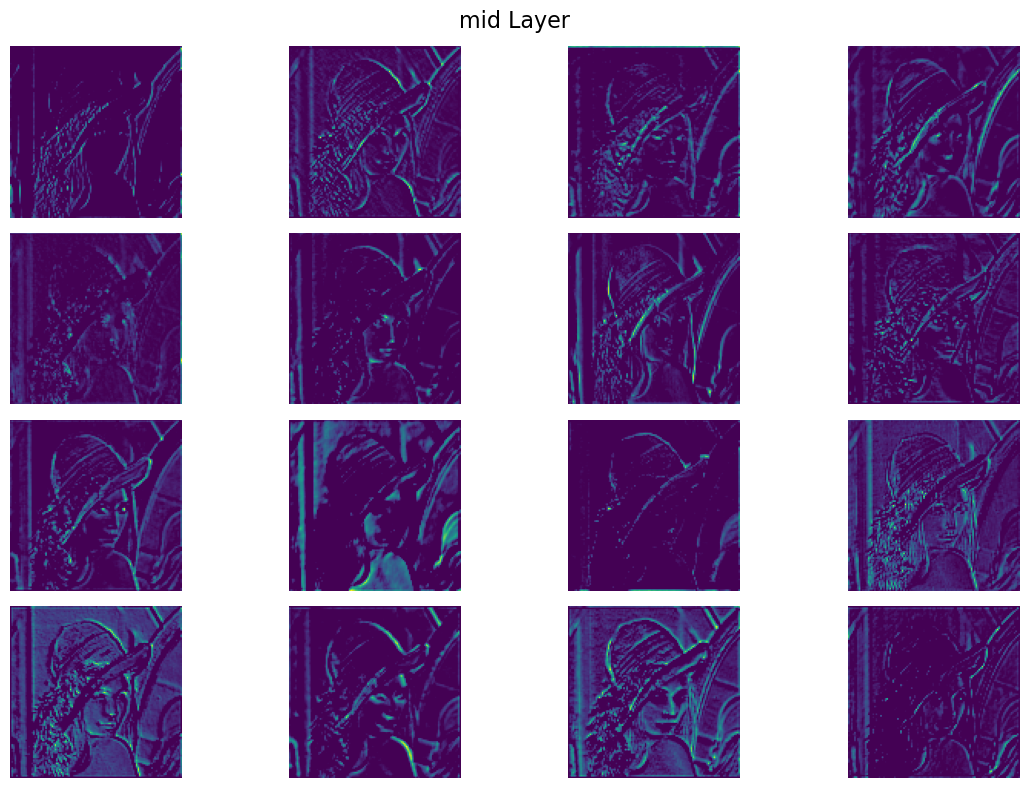

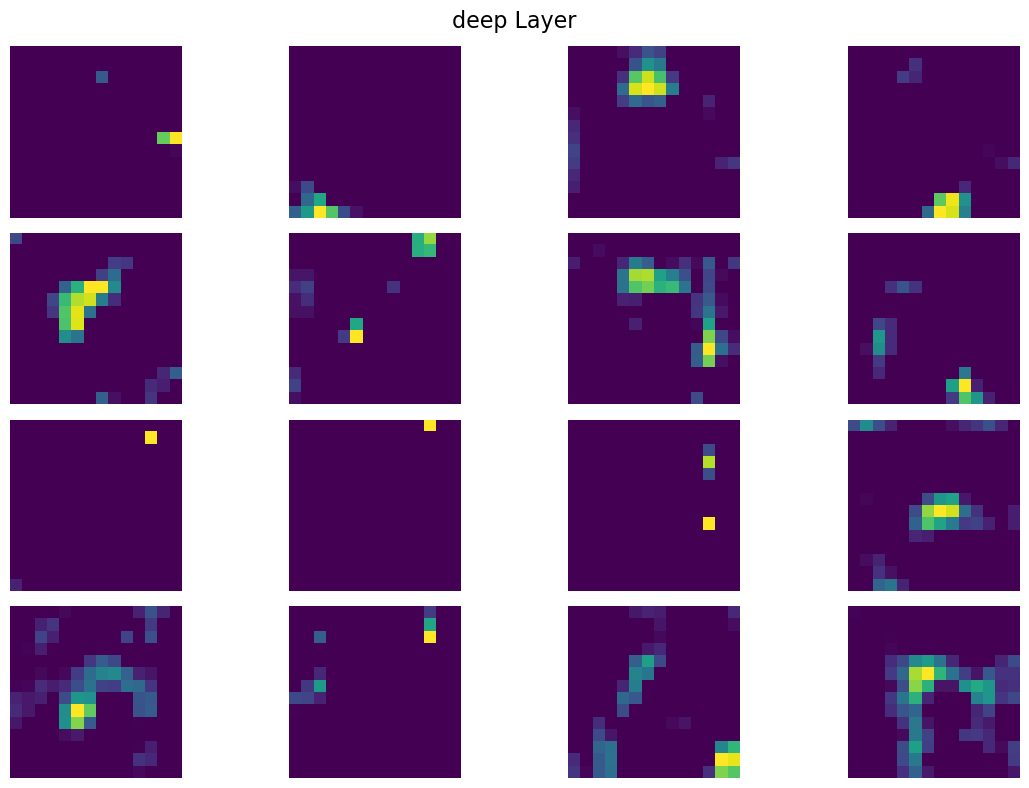

In [18]:
displayFeatureMaps(activations[model.features[0]], "shallow Layer")
displayFeatureMaps(activations[model.features[5]], "mid Layer")
displayFeatureMaps(activations[model.features[28]], "deep Layer")

### Task 3: Crafting Noise Images & Analyzing Impact on CNN

1. Generate Noisy Images

In [19]:
noise_intensity_images = {}
def gen_noise_intensity(noise_type, intensityLevels = 2):
    for i in range(1, intensityLevels+1):
        if noise_type == "gaussian":
            noise_intensity_images[f"{noise_type}_intensityLvl_{i}"] = gaussian(original, mean=0, std=25, intensity=i)
        elif noise_type == "saltNpepper":
            noise_intensity_images[f"{noise_type}_intensityLvl_{i}"] = saltNpepper(original, salt_prob=0.01, pepper_prob=0.01, intensity=i)
        elif noise_type == "poisson":
            noise_intensity_images[f"{noise_type}_intensityLvl_{i}"] = poisson(original, intensity=i)


gen_noise_intensity(noise_type="saltNpepper", intensityLevels = 4)

2. Pass Noisy Images Through the CNN

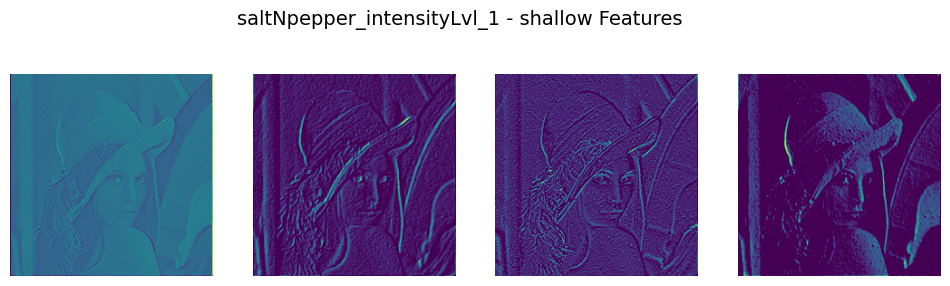

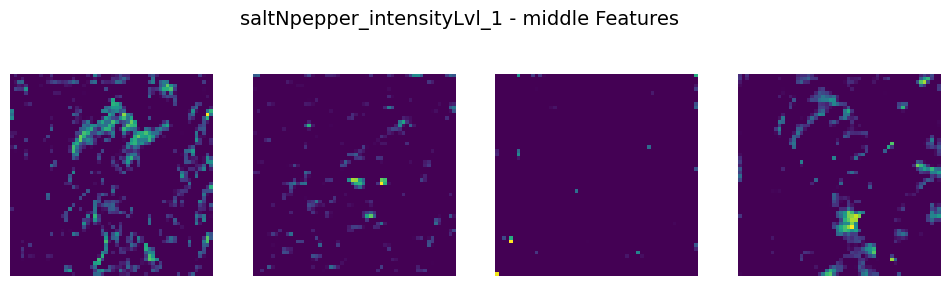

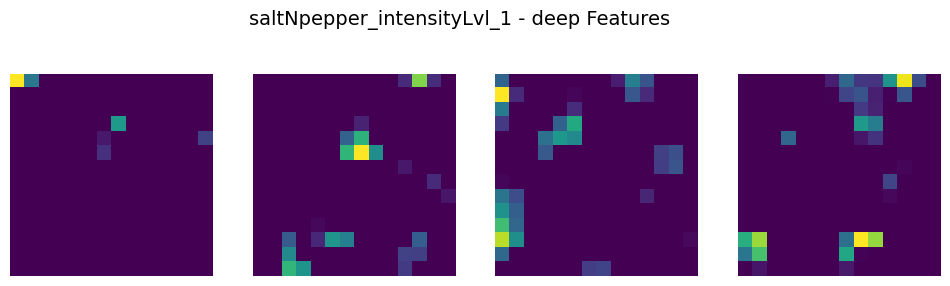

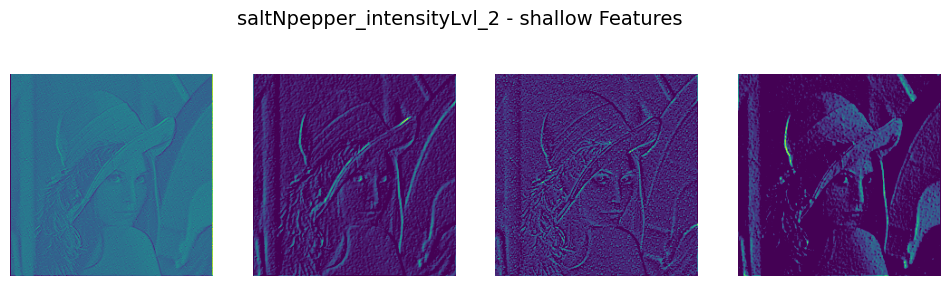

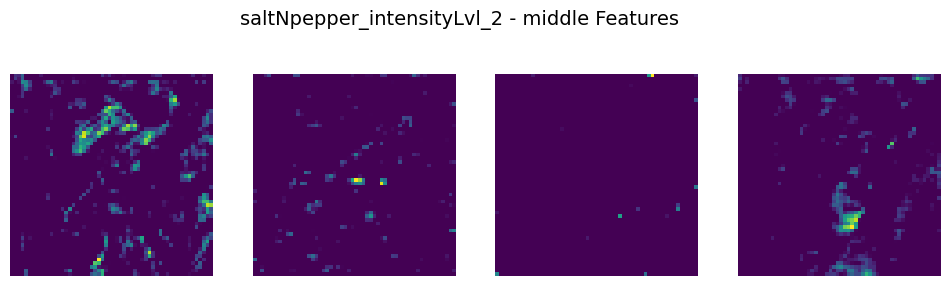

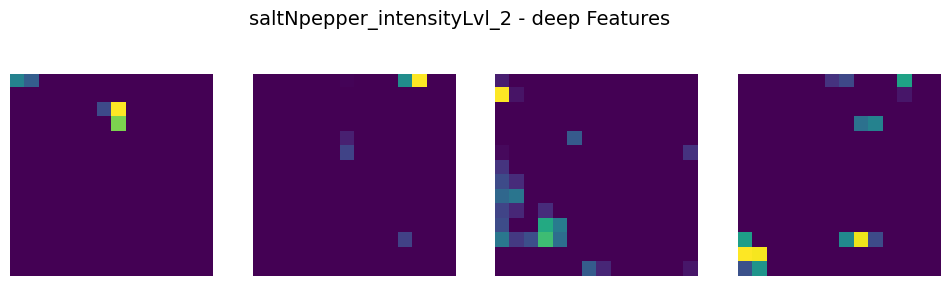

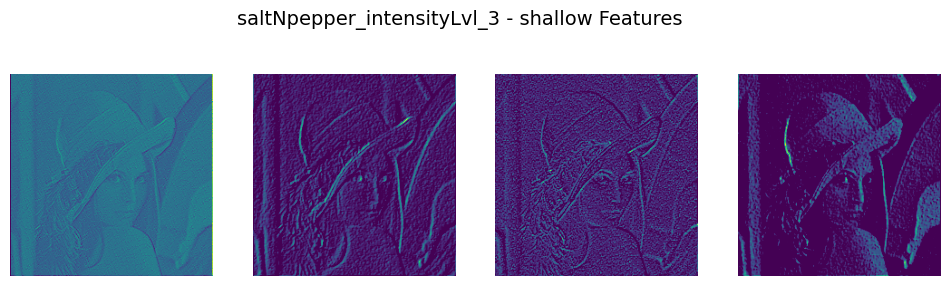

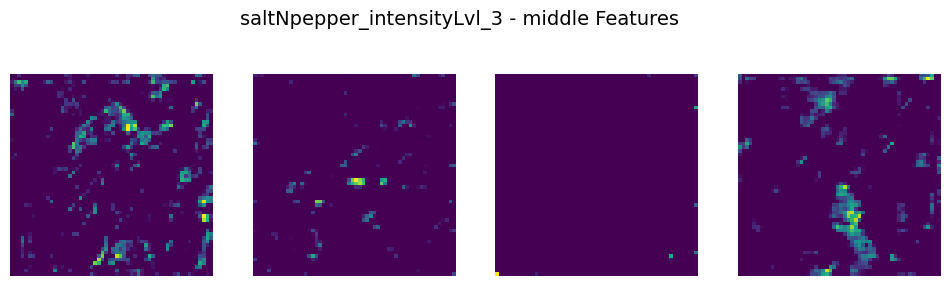

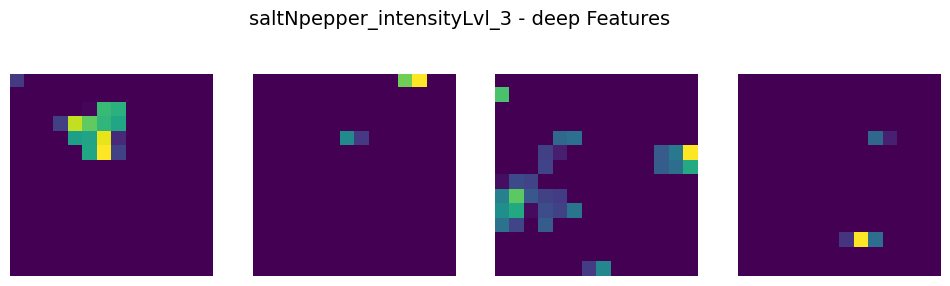

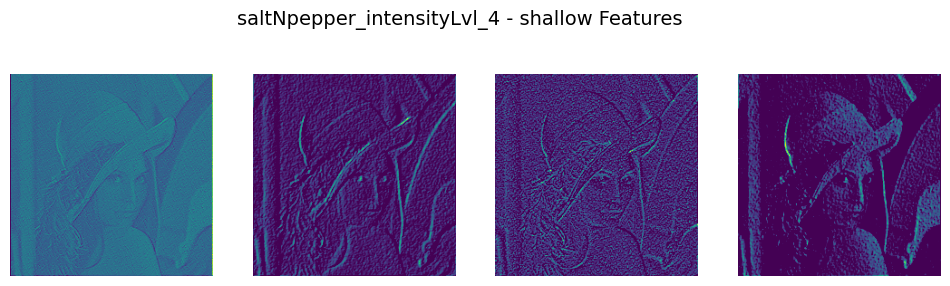

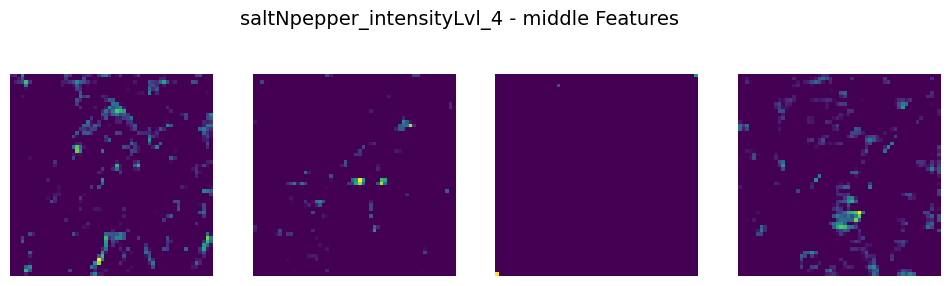

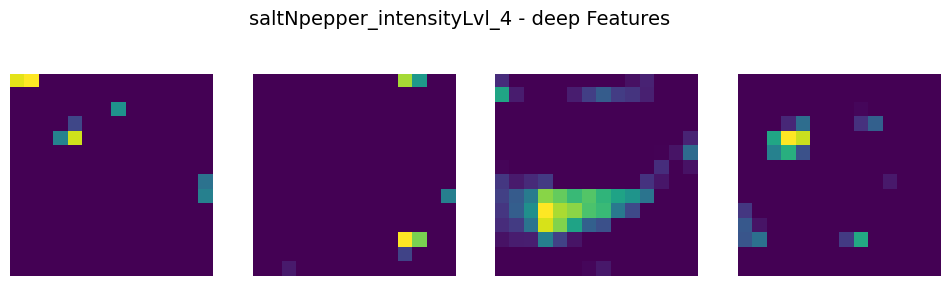

In [20]:
activations = {}
def hook_fn(module, input, output):
    '''
    TODO: Hook function to store activations from a convolutional layer
    \param module (torch.nn.Module): The layer from which activations are captured
    \param input (torch.Tensor): Input tensor to the layer
    \param output (torch.Tensor): Output tensor from the layer

    \return None: stores the activations in the activations dictionary
    '''
    activations[module] = output

model.features[0].register_forward_hook(hook_fn)   # first layer 
model.features[14].register_forward_hook(hook_fn)  # middle layer 
model.features[28].register_forward_hook(hook_fn)  # last layer 

def convert_to_rgb(image):
    '''
    TODO: Convert a grayscale image to RGB
    \param image (numpy.ndarray): input image array

    \return rgb_image (numpy.ndarray): RGB image array
    '''
    if len(image.shape) == 2:
        return np.stack([image] * 3, axis=-1)  
    return image 

feature_maps = {}
for title, img in noise_intensity_images.items():
    rgb_image = convert_to_rgb(img)
    pil_image = Image.fromarray(rgb_image)
    input_tensor = preprocess(pil_image).unsqueeze(0)

    with torch.no_grad():
        _ = model(input_tensor)  
        feature_maps[title] = {
            "shallow": activations[model.features[0]],
            "middle": activations[model.features[14]],
            "deep": activations[model.features[28]]
        }

def displayIntensityFeatureMaps(feature_maps, title):
    '''
    TODO: Display feature maps for different intensity levels
    \param feature_maps (dict): dictionary containing feature maps for different intensity levels
    \param title (str): title of the feature maps

    \return None: displays the feature maps
    '''
    shallow_maps = feature_maps["shallow"].squeeze(0).cpu().numpy()
    middle_maps = feature_maps["middle"].squeeze(0).cpu().numpy()
    deep_maps = feature_maps["deep"].squeeze(0).cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(4):  
        plt.subplot(2, 8 // 2, i + 1)
        plt.imshow(shallow_maps[i], cmap='viridis')
        plt.axis('off')
        plt.suptitle(f"{title} - shallow Features", fontsize=14)

    plt.figure(figsize=(12, 6))
    for i in range(4):  
        plt.subplot(2, 8 // 2, i + 1)
        plt.imshow(middle_maps[i], cmap='viridis')
        plt.axis('off')
        plt.suptitle(f"{title} - middle Features", fontsize=14)

    plt.figure(figsize=(12, 6))
    for i in range(4): 
        plt.subplot(2, 8 // 2, i + 1)
        plt.imshow(deep_maps[i], cmap='viridis')
        plt.axis('off')
        plt.suptitle(f"{title} - deep Features", fontsize=14)

# feature maps for all noisy images
for title in noise_intensity_images.keys():
    displayIntensityFeatureMaps(feature_maps[title], title)

3. Analyze Performance Drop

In [21]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

softmax = torch.nn.Softmax(dim=1)
for title, img in Noisy_Images.items():
    if len(img.shape) == 2: 
        img = np.stack([img] * 3, axis=-1)
    pil_image = Image.fromarray(img)

    input_tensor = preprocess(pil_image).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)       
        probs = softmax(logits)            

        top_prob, top_class = torch.max(probs, dim=1)
        print(f"{title}: Confidence {top_prob.item():.4f}") 

original: Confidence 0.4314
gaussian: Confidence 0.3151
saltNpepper: Confidence 0.0668
poisson: Confidence 0.3828


In [22]:
def adversarialAttack(image, epsilon, dataGd):
    '''
        TODO: Adversial perturbation: FGSM attack
        \param image (torch.Tensor): input image tensor
        \param epsilon (float): perturbation magnitude
        \param dataGd (torch.Tensor): gradients of loss w.r.t input image

        \return perturbed_image (torch.Tensor): perturbed image
    '''
    sign_dataGd = dataGd.sign()
    perturbed_image = image + epsilon * sign_dataGd
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

rgb_image = convert_to_rgb(Noisy_Images["original"])
pil_image = Image.fromarray(rgb_image)
input_tensor = preprocess(pil_image).unsqueeze(0) 
input_tensor.requires_grad = True

output = model(input_tensor)
target_class = output.argmax(1)  
loss = torch.nn.CrossEntropyLoss()(output, target_class)

model.zero_grad()
loss.backward()
adversarial_image = adversarialAttack(input_tensor, epsilon = 0.01, dataGd = input_tensor.grad.data)

with torch.no_grad():
    adv_output = model(adversarial_image)
    adv_probs = torch.nn.Softmax(dim=1)(adv_output)
    adv_top_prob, adv_top_class = torch.max(adv_probs, dim=1)

print(f"Adversarial Confidence: {adv_top_prob.item():.4f}") 

Adversarial Confidence: 0.7631
